# Titanic — Machine Learning from Disaster

# 1. Imports

We set up a **reproducible environment** using a focused set of libraries:

- **NumPy** and **pandas** for numerical computing and tabular data manipulation.
- **Matplotlib** and **Seaborn** for visualisations.
- **Pathlib** for OS-independent file paths.
- Standard modules like `random` and `os` to control pseudo-randomness and environment variables.

A global `RANDOM_STATE` is defined and applied consistently (NumPy, Python `random`, hash seed), and Seaborn’s style is configured to ensure all figures share a coherent visual identity. Additional libraries are imported later when needed:

- **scikit-learn** for preprocessing, model training, cross-validation, and evaluation.
- **TensorFlow / Keras** for the Multilayer Perceptron (MLP).
- **Optuna** for advanced hyperparameter optimisation.


In [79]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import os

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)

pd.set_option("display.max_columns", None)

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme(context="notebook", style="whitegrid")

DATA_DIR = Path("DATA")

# 2. Data imports

We work with the **Kaggle Titanic** dataset stored in `DATA_DIR`:

- `train.csv` -> `train` DataFrame (contains the target `Survived`).
- `test.csv` -> `test` DataFrame (no `Survived` column).

Key points:

- **Train shape:** 891 rows × 12 columns.
- **Test shape:** 418 rows × 11 columns.
- Training features include:
  - Passenger descriptors (`Pclass`, `Name`, `Sex`, `Age`, `SibSp`, `Parch`, `Ticket`, `Fare`, `Cabin`, `Embarked`).
  - Identifier `PassengerId`.
  - Target `Survived` (0 = did not survive, 1 = survived).

Initial inspection confirms:

- `PassengerId` is purely an identifier.
- Text-like fields (`Name`, `Ticket`, `Cabin`) will be mined for features.
- Categorical variables (`Sex`, `Embarked`, `Pclass`) and continuous variables (`Age`, `Fare`) are correctly loaded and ready for analysis.


In [80]:
# 2 Data imports
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

print(f"Train shape : {train.shape}")
print(f"Test shape  : {test.shape}")

train.head()

Train shape : (891, 12)
Test shape  : (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 3. Exploratory Data Analysis (3.1–3.12)

The EDA phase builds an understanding of both **data quality** and **survival patterns**.

**Structure and basic stats**

- `train.info()` reveals:
  - Numeric columns (e.g. `Age`, `SibSp`, `Parch`, `Fare`, `Pclass`, `Survived`).
  - Categorical/text columns (`Sex`, `Embarked`, `Name`, `Ticket`, `Cabin`).
- `describe()` shows:
  - Moderate **class imbalance** (~38% survivors vs ~62% non-survivors).
  - Right-skewed `Fare` with a few very high values.
  - Most passengers have few or no family members on board.

**Missing data**

- **Cabin**: mostly missing -> use only **deck letter** and a **has/has_not** indicator.
- **Age**: partially missing -> will be imputed using **(Title, Pclass)** group medians.
- **Embarked**: a few missing values -> filled with the most frequent port.
- **Fare**: one missing value in test -> filled with the median fare.

**Target and key relationships**

- **Survived distribution**:
  - Non-survivors are the majority; accuracy must be interpreted with this imbalance in mind.
- **Sex**:
  - Females have a much higher survival rate than males, reflecting “women and children first”.
- **Class (`Pclass`)**:
  - Survival improves from 3rd -> 2nd -> 1st class; `Pclass` is a very strong predictor.
- **Embarked**:
  - Passengers from Cherbourg (C) show higher survival than those from Southampton (S) or Queenstown (Q).

**Engineered signals from EDA**

- **Family features**:
  - `FamilySize = SibSp + Parch + 1`.
  - `IsAlone = 1` if `FamilySize == 1`.
  - Small/medium families have higher survival; lone travellers and very large families fare worse.
- **Age**:
  - Children have higher survival; elderly passengers fare worse.
  - Binary flags such as `Kid` (Age < 10) and `Old` (Age > 65) capture this.
- **Fare**:
  - Strong right skew → apply `Fare_log = log(1 + Fare)` to stabilise variance.
  - Higher (log) fares correlate with higher survival.
- **Cabin**:
  - Use `CabinDeck` (first letter or `"Unknown"`) and `HasCabin` (binary).
  - Known cabins and certain decks are associated with higher survival.
- **Titles**:
  - Extract `Title` from `Name` and group rare titles into `"Rare"`.
  - `Title` strongly correlates with gender, social status, and age, and thus with survival.

This EDA directly drives the feature-engineering strategy used in the subsequent pipeline.


In [81]:
# 3.1 General Overview

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [82]:
#3.2 Numerical Descriptive Statistics

train.describe(include=[np.number])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Missing values rate - Train: :


Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64


Missing values rate - Test :


Cabin    0.782297
Age      0.205742
Fare     0.002392
dtype: float64

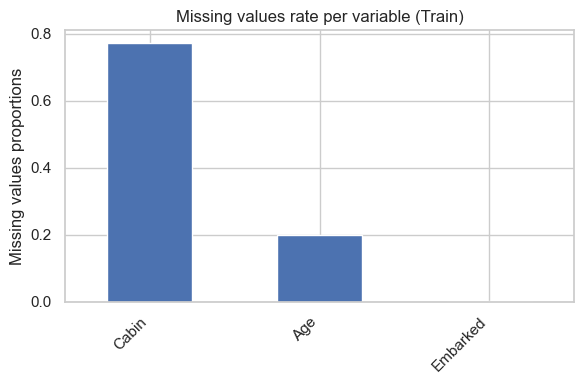

In [83]:
# 3.3 Missing Data (train and test)

missing_train = train.isna().mean().sort_values(ascending=False)
missing_test = test.isna().mean().sort_values(ascending=False)

print("Missing values rate - Train: :")
display(missing_train[missing_train > 0])

print("\nMissing values rate - Test :")
display(missing_test[missing_test > 0])

missing_train_plot = missing_train[missing_train > 0]

plt.figure(figsize=(6, 4))
missing_train_plot.plot(kind="bar")
plt.title("Missing values rate per variable (Train)")
plt.ylabel("Missing values proportions")
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Counts:


Survived
0    549
1    342
Name: count, dtype: int64


Ratios:


Survived
0    0.616162
1    0.383838
Name: count, dtype: float64

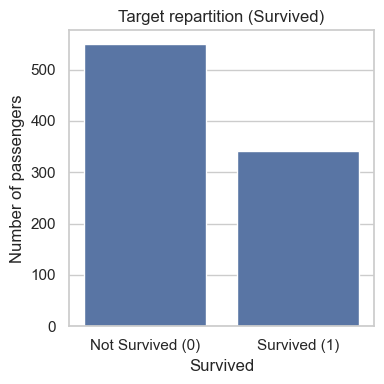

In [84]:
# 3.4 Target Distribution: Survived

target_counts = train["Survived"].value_counts().sort_index()
target_ratio = target_counts / target_counts.sum()

print("Counts:")
display(target_counts)
print("\nRatios:")
display(target_ratio)

plt.figure(figsize=(4, 4))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.xticks([0, 1], ["Not Survived (0)", "Survived (1)"])
plt.ylabel("Number of passengers")
plt.title("Target repartition (Survived)")
plt.tight_layout()
plt.show()

Survived,0,1,Survival_rate
Sex,,,
female,81,233,0.742038
male,468,109,0.188908


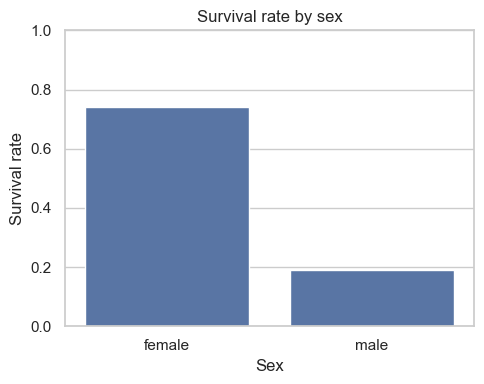

In [85]:
# 3.5 Survival by Sex

sex_survival = pd.crosstab(train["Sex"], train["Survived"])
sex_survival["Survival_rate"] = sex_survival[1] / (sex_survival[0] + sex_survival[1])

display(sex_survival)

plt.figure(figsize=(5, 4))
sns.barplot(x=sex_survival.index, y=sex_survival["Survival_rate"].values)
plt.ylabel("Survival rate")
plt.title("Survival rate by sex")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Survived,0,1,Survival_rate
Pclass,,,
1,80,136,0.629630
2,97,87,0.472826
3,372,119,0.242363


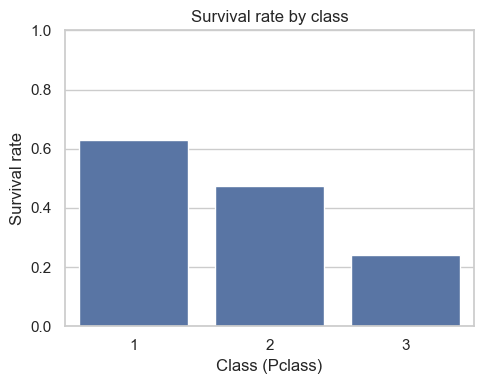

In [86]:
# 3.6 Survival by Class (Pclass)

pclass_survival = pd.crosstab(train["Pclass"], train["Survived"])
pclass_survival["Survival_rate"] = pclass_survival[1] / (pclass_survival[0] + pclass_survival[1])

display(pclass_survival)

plt.figure(figsize=(5, 4))
sns.barplot(
    x=pclass_survival.index.astype(str),
    y=pclass_survival["Survival_rate"].values
)
plt.xlabel("Class (Pclass)")
plt.ylabel("Survival rate")
plt.title("Survival rate by class")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Survived,0,1,Survival_rate
Embarked,,,
C,75,93,0.553571
Q,47,30,0.389610
S,427,217,0.336957


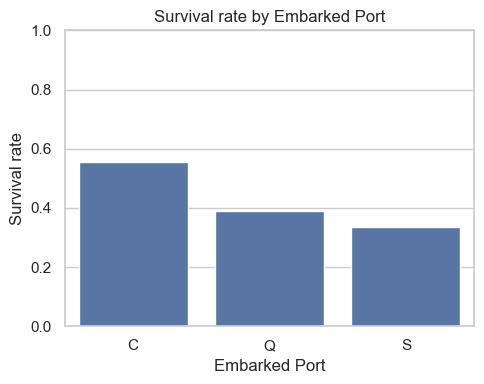

In [87]:
# 3.7 Survival by Embarked Port

embarked_survival = pd.crosstab(train["Embarked"], train["Survived"])
embarked_survival["Survival_rate"] = embarked_survival[1] / (embarked_survival[0] + embarked_survival[1])

display(embarked_survival)

plt.figure(figsize=(5, 4))
sns.barplot(
    x=embarked_survival.index.astype(str),
    y=embarked_survival["Survival_rate"].values
)
plt.xlabel("Embarked Port")
plt.ylabel("Survival rate")
plt.title("Survival rate by Embarked Port")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

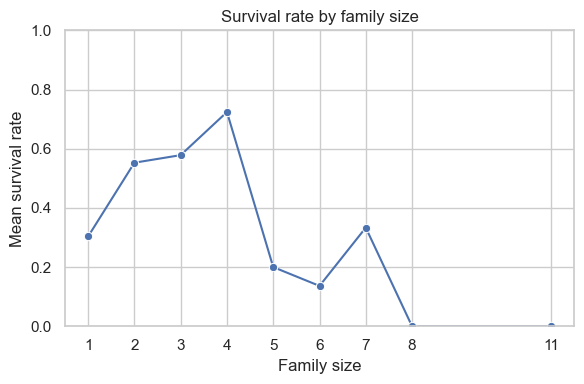


Survival rate by IsAlone :


IsAlone
0    0.505650
1    0.303538
Name: Survived, dtype: float64

In [88]:
# 3.8 Family Size and Isolation

train_sa = train.copy()

train_sa["FamilySize"] = train_sa["SibSp"] + train_sa["Parch"] + 1
train_sa["IsAlone"] = (train_sa["FamilySize"] == 1).astype(int)

family_survival = (
    train_sa.groupby("FamilySize")["Survived"]
    .mean()
    .reset_index()
    .sort_values("FamilySize")
)

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=family_survival,
    x="FamilySize",
    y="Survived",
    marker="o"
)
plt.xlabel("Family size")
plt.ylabel("Mean survival rate")
plt.title("Survival rate by family size")
plt.xticks(family_survival["FamilySize"].unique())
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("\nSurvival rate by IsAlone :")
display(train_sa.groupby("IsAlone")["Survived"].mean())

In [89]:
display(family_survival)

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


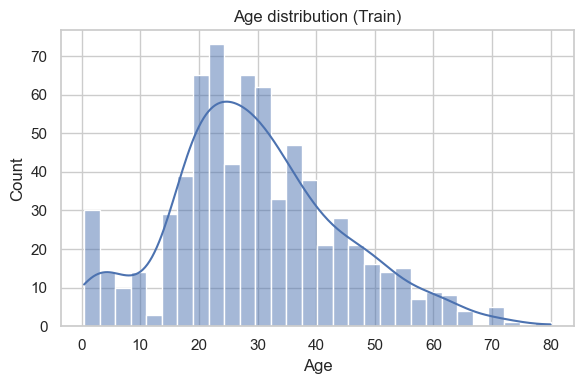

Survival rate by age bin :


/var/folders/0f/_fg7x2451bj2lywhltbl4j3w0000gn/T/ipykernel_69244/2061714339.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agebin_survival = train_sa.groupby("AgeBin")["Survived"].mean()


AgeBin
0-12     0.579710
12-18    0.428571
18-30    0.355556
30-50    0.423237
50+      0.343750
Name: Survived, dtype: float64

In [90]:
# 3.9 Age: Distribution and Survival Relationship

plt.figure(figsize=(6, 4))
sns.histplot(train_sa["Age"].dropna(), bins=30, kde=True)
plt.xlabel("Age")
plt.title("Age distribution (Train)")
plt.tight_layout()
plt.show()

age_bins = [0, 12, 18, 30, 50, 80]
age_labels = ["0-12", "12-18", "18-30", "30-50", "50+"]

train_sa["AgeBin"] = pd.cut(train_sa["Age"], bins=age_bins, labels=age_labels, include_lowest=True)
agebin_survival = train_sa.groupby("AgeBin")["Survived"].mean()

print("Survival rate by age bin :")
display(agebin_survival)

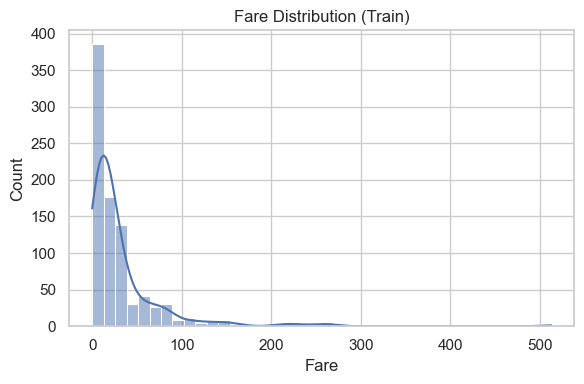

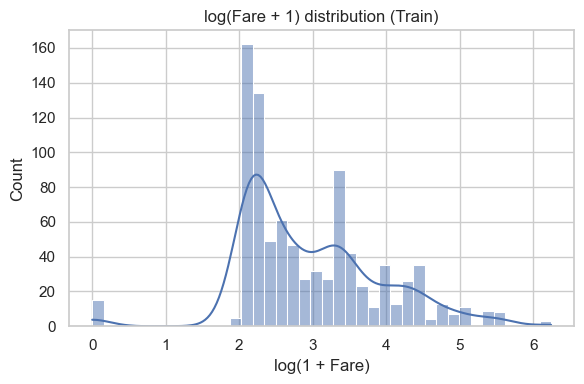

In [91]:
# 3.10 Fare: Distribution and Log-Transform

plt.figure(figsize=(6, 4))
sns.histplot(train_sa["Fare"], bins=40, kde=True)
plt.xlabel("Fare")
plt.title("Fare Distribution (Train)")
plt.tight_layout()
plt.show()

train_sa["Fare_log_tmp"] = np.log1p(train_sa["Fare"])

plt.figure(figsize=(6, 4))
sns.histplot(train_sa["Fare_log_tmp"], bins=40, kde=True)
plt.xlabel("log(1 + Fare)")
plt.title("log(Fare + 1) distribution (Train)")
plt.tight_layout()
plt.show()

train_sa.drop(columns=["Fare_log_tmp"], inplace=True)

In [ ]:
# 3.11 Cabin: Missingness and CabinDeck / HasCabin

train_sa["HasCabin"] = (~train_sa["Cabin"].isna()).astype(int)

print("Proportion of passengers with known cabin :", train_sa["HasCabin"].mean())

print("\nSurvival rate by wether cabin or not :")
display(train_sa.groupby("HasCabin")["Survived"].mean())

train_sa["CabinDeck_tmp"] = train_sa["Cabin"].astype(str).str[0]
deck_survival = train_sa[train_sa["HasCabin"] == 1].groupby("CabinDeck_tmp")["Survived"].mean().sort_values()

print("\nSurvival rate by deck (on passengers with known cabin) :")
display(deck_survival)

Proportion of passengers with known cabin : 0.22895622895622897

Survival rate by wether cabin or not :


HasCabin
0    0.299854
1    0.666667
Name: Survived, dtype: float64


Survival rate by deck (on passengers with known cabin) :


CabinDeck_tmp
T    0.000000
A    0.466667
G    0.500000
C    0.593220
F    0.615385
B    0.744681
E    0.750000
D    0.757576
Name: Survived, dtype: float64

In [93]:
# 3.12 Titles: Extracting the Title Feature from Name

train_sa["Title_tmp"] = train_sa["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()

title_counts = train_sa["Title_tmp"].value_counts()
print("Most frequent raw titles :")
display(title_counts.head(10))

title_survival = (
    train_sa.groupby("Title_tmp")["Survived"]
    .mean()
    .sort_values(ascending=False)
)

print("\nSurvival rate by Title :")
display(title_survival.head(10))

Most frequent raw titles :


Title_tmp
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Name: count, dtype: int64


Survival rate by Title :


Title_tmp
the Countess    1.000000
Mlle            1.000000
Sir             1.000000
Ms              1.000000
Lady            1.000000
Mme             1.000000
Mrs             0.792000
Miss            0.697802
Master          0.575000
Col             0.500000
Name: Survived, dtype: float64

In [94]:
train_sa.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,AgeBin,HasCabin,CabinDeck_tmp,Title_tmp
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,18-30,0,n,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,30-50,1,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,18-30,0,n,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,30-50,1,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,30-50,0,n,Mr


In [95]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 4. Feature Engineering – TitanicFeatureBuilder & TargetEncoder

To avoid shaky transformations and data leakage, all feature engineering is wrapped in two custom transformers:

## TitanicFeatureBuilder

A scikit-learn–compatible transformer that:

- **Cleans and imputes data**
  - Fills missing `Embarked` with the most frequent port.
  - Imputes missing `Fare` (test) with the median.
  - Creates `Age_imp` by imputing `Age` using median ages within `(Title, Pclass)` groups.

- **Creates engineered features**
  - Family-related: `FamilySize`, `IsAlone`, and a categorical `FamilySizeGroup` (small / medium / large).
  - Age-related: `Kid` (Age < 10), `Old` (Age > 65).
  - Cabin-related: `CabinDeck` (deck letter or `"Unknown"`), `HasCabin` (binary).
  - Name/Ticket-derived: `Title` (with rare titles regrouped) and `Ticket_Frequency` (count of passengers sharing the same ticket).

- **Outputs a clean schema**
  - Drops raw text fields not needed downstream, while keeping original core features and all engineered ones.

## TargetEncoder

A custom transformer that **target-encodes** selected categorical features:

- Encoded columns: `Title`, `CabinDeck`, `FamilySizeGroup`.
- For each category, computes a **smoothed survival rate**:
  - Blends the global mean with the category-specific mean, weighted by category frequency.
- Produces new numeric columns (`Title_te`, `CabinDeck_te`, `FamilySizeGroup_te`).
- Handles unseen categories at prediction time by falling back to the global mean.

Both transformers follow the scikit-learn API, so they are fitted **inside cross-validation folds**, ensuring **no leakage** and a consistent feature space for all models.


In [96]:
# 4. Feature Engineering - TitanicFeatureBuilder
from sklearn.base import BaseEstimator, TransformerMixin

class TitanicFeatureBuilder(BaseEstimator, TransformerMixin):

    def __init__(self, min_title_count=10, min_deck_count=10):
        self.min_title_count = min_title_count
        self.min_deck_count = min_deck_count
        self.family_map = {
            1: "Alone",
            2: "Small",
            3: "Small",
            4: "Small",
            5: "Medium",
            6: "Medium",
            7: "Large",
            8: "Large",
            11: "Large",
        }

    def fit(self, X, y=None):
        df = X.copy()

        df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()
        df["Title"] = df["Title"].replace({
            "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs", "Master": "Master"
        })

        title_counts = df["Title"].value_counts()
        rare_titles = title_counts[title_counts < self.min_title_count].index
        self.rare_titles_ = set(rare_titles)

        self.valid_titles_ = set(title_counts.index) | {"Rare"}

        df["HasCabin"] = (~df["Cabin"].isna()).astype(int)
        df["CabinDeck"] = df["Cabin"].astype(str).str[0]
        df["CabinDeck"] = df["CabinDeck"].where(df["HasCabin"] == 1, "U")

        deck_counts = df["CabinDeck"].value_counts()
        rare_decks = deck_counts[deck_counts < self.min_deck_count].index

        self.rare_decks_ = set(rare_decks)
        self.valid_decks_ = set(deck_counts.index) | {"URare"}

        self.embarked_mode_ = df["Embarked"].mode()[0]
        self.fare_median_ = df["Fare"].median()
        self.age_global_median_ = df["Age"].median()

        df["Title"] = df["Title"].where(~df["Title"].isin(self.rare_titles_), "Rare")
        df["Title"] = df["Title"].fillna("Rare")

        df["CabinDeck"] = df["CabinDeck"].where(~df["CabinDeck"].isin(self.rare_decks_), "URare")

        self.age_medians_ = (
            df.groupby(["Title", "Pclass"])["Age"]
            .median()
        )


        return self

    def transform(self, X):
        df = X.copy()

        df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()
        df["Title"] = df["Title"].replace({
            "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"
        })

        df["Title"] = df["Title"].where(~df["Title"].isin(self.rare_titles_), "Rare")
        df["Title"] = df["Title"].fillna("Rare")

        df.loc[~df["Title"].isin(self.valid_titles_), "Title"] = "Rare"

        df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1
        df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
        df["FamilySizeGroup"] = df["FamilySize"].map(self.family_map).fillna("Large")

        df["HasCabin"] = (~df["Cabin"].isna()).astype(int)
        df["CabinDeck"] = df["Cabin"].astype(str).str[0]
        df["CabinDeck"] = df["CabinDeck"].where(df["HasCabin"] == 1, "U")

        df["CabinDeck"] = df["CabinDeck"].where(~df["CabinDeck"].isin(self.rare_decks_), "URare")

        df.loc[~df["CabinDeck"].isin(self.valid_decks_), "CabinDeck"] = "URare"

        df["Embarked"] = df["Embarked"].fillna(self.embarked_mode_)
        df["Fare"] = df["Fare"].fillna(self.fare_median_)

        def impute_age(row):
            age = row["Age"]
            if pd.notna(age):
                return age
            key = (row["Title"], row["Pclass"])
            if key in self.age_medians_ and not np.isnan(self.age_medians_[key]):
                return self.age_medians_[key]
            return self.age_global_median_

        df["Age_imp"] = df.apply(impute_age, axis=1)

        df["Kid"] = (df["Age_imp"] < 10).astype(int)
        df["Old"] = (df["Age_imp"] > 65).astype(int)

        df["Fare_log"] = np.log1p(df["Fare"])

        if hasattr(self, "ticket_freq_") and self.ticket_freq_ is not None and "Ticket" in df.columns:
            df["Ticket_Frequency"] = df["Ticket"].map(self.ticket_freq_).fillna(1).astype(int)
        else:
            df["Ticket_Frequency"] = 1

        # Final columns
        cols = [
            "Pclass",
            "Sex",
            "Embarked",
            "Title",
            "CabinDeck",
            "FamilySize",
            "FamilySizeGroup",
            "IsAlone",
            "HasCabin",
            "Age_imp",
            "Fare_log",
            "Kid",
            "Old",
            "Ticket_Frequency",
            "PassengerId",
        ]
        cols = [c for c in cols if c in df.columns]

        return df[cols]

In [97]:
# 4.1 Feature Engineering - TargetEncoder
class TargetEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, cols, smoothing=10.0):
        self.cols = cols
        self.smoothing = smoothing

    def fit(self, X, y):
        import pandas as pd
        import numpy as np

        self.global_mean_ = float(np.mean(y))
        self.enc_maps_ = {}

        X_ = pd.DataFrame(X).copy()
        y_ = pd.Series(y)

        for col in self.cols:
            if col not in X_.columns:
                continue

            stats = (
                pd.DataFrame({col: X_[col], "target": y_})
                .groupby(col)["target"]
                .agg(["mean", "count"])
            )

            # smoothing to avoid exploding the rare categories
            smoothing = 1 / (1 + np.exp(-(stats["count"] - self.smoothing)))
            enc = self.global_mean_ * (1 - smoothing) + stats["mean"] * smoothing

            self.enc_maps_[col] = enc

        return self

    def transform(self, X):
        import pandas as pd

        X_ = pd.DataFrame(X).copy()
        for col, enc in self.enc_maps_.items():
            te_col = f"{col}_te"
            X_[te_col] = X_[col].map(enc).fillna(self.global_mean_)
        return X_

# 5. Classical ML Models, Tuning & Results (Sections 4–5.12)

All models share a **common preprocessing and evaluation setup** before tuning:

## Common preprocessor & validation strategy

- **Preprocessing (`preprocessor`)**
  - Numeric features (e.g. `Age_imp`, `FamilySize`, `Fare_log`, `Kid`, `Old`, `HasCabin`, `Ticket_Frequency`, and target-encoded variables) are scaled with `StandardScaler`.
  - Remaining categorical features (`Sex`, `Pclass`, `Embarked`, etc.) are one-hot encoded with `OneHotEncoder(handle_unknown="ignore")`.
- **Validation**
  - 10-fold **StratifiedKFold** is used for all models, ensuring consistent, reliable performance estimates. (Best results observed)

A generic `evaluate_model` helper runs `cross_val_score` and then reports mean and std accuracy.

## Baseline models

Each model is wrapped in a pipeline:

1. `TitanicFeatureBuilder` -> `TargetEncoder` -> `preprocessor` -> classifier.
2. Evaluated with the same 10-fold CV.

Models:

- **Logistic Regression**
  - Achieves accuracy in the low 80% range with low variance.
- **Random Forest**
  - Typically outperforms Logistic Regression.
- **Gradient Boosting**
  - Sequentially corrects errors, slightly better than Random Forest.
- **Voting Classifier (soft)**
  - Combines Logistic Regression, Random Forest, and Gradient Boosting pipelines.
  - Soft voting over probabilities show an accuracy at least as high as the best individual model. (Before tuning)

## Hyperparameter tuning

A helper `run_grid_search` with `GridSearchCV` is used to tune:

- **Logistic Regression (tuned)**
  - Grid over `C`, `solver`, and target-encoder `smoothing`.
  - Gains are modest.

- **Random Forest (tuned)**
  - Grid over `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, and `smoothing`.
  - Achieves higher mean CV accuracy.

- **Gradient Boosting (tuned via grid search)**
  - Grid over `learning_rate`, `n_estimators`, `max_depth`, `min_samples_leaf`, `subsample`, and `smoothing`.
  - Becomes one of the strongest single models.

- **Gradient Boosting (Optuna-tuned)**
  - Optuna explores a richer, continuous hyperparameter space for the same model.
  - Typically matches or slightly outperforms the grid-search version.

- **Voting Classifier (tuned models)**
  - Uses the tuned Logistic Regression, Random Forest, and Gradient Boosting as base learners.
  - Single models are better performing.

- **Tuned Voting Classifier**
  - Uses a grid search and parameters on weights for Logistic Regression, Random Forest, and Gradient Boosting .
  - Single models and base Voting classifier are better performing.

## Tuned results

A consolidated table of tuned models shows:

- **Top performers**: Optuna-tuned Gradient Boosting and the tuned Gradient Boosing, with mean accuracies in the mid-80% range and small standard deviations.
- **Tuned Random Forest and Logistic Regression**: slightly behind but still strong.
- **Voting Classifiers** aren't worth the trouble.


In [98]:
# 5. Common Preprocessor & Validation Strategy

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

te_cols = ["Title", "CabinDeck", "FamilySizeGroup"]
numeric_features = [
    "Age_imp",
    "FamilySize",
    "Fare_log",
    "Kid",
    "Old",
    "HasCabin",
    "Ticket_Frequency",
    "Title_te",
    "CabinDeck_te",
    "FamilySizeGroup_te",
]
categorical_features = [
    "Pclass",
    "Sex",
    "Embarked",
    "IsAlone",
]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="if_binary"), categorical_features),
    ],
    remainder="drop",
)

cv = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=RANDOM_STATE
)

X = train.drop(columns=["Survived"])
y = train["Survived"]

In [99]:
# 5.1 Evaluation Function

def evaluate_model(name, model, X, y, cv):
    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    mean_score = scores.mean()
    std_score = scores.std()
    print(f"{name:<25} {mean_score:.4f} ± {std_score:.4f}")
    return {
        "Model": name,
        "CV_Accuracy_Mean": mean_score,
        "CV_Accuracy_Std": std_score,
    }

In [100]:
# 5.2 Logistic Regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg_clf = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(
        max_iter=500,
        C=1.0,
        solver="lbfgs",
        random_state=RANDOM_STATE
    )),
])

log_reg_result = evaluate_model("Logistic Regression", log_reg_clf, X, y, cv)

Logistic Regression       0.8226 ± 0.0272


In [101]:
# 5.3 Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
])

rf_result = evaluate_model("Random Forest", rf_clf, X, y, cv)

Random Forest             0.8215 ± 0.0251


In [102]:
# 5.4 Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
    ("clf", GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=200,
        max_depth=3,
        min_samples_leaf=2,
        random_state=RANDOM_STATE
    )),
])

gb_result = evaluate_model("Gradient Boosting", gb_clf, X, y, cv)

Gradient Boosting         0.8248 ± 0.0288


In [103]:
# 5.4 Voting Classifier
from sklearn.ensemble import VotingClassifier

log_reg_base = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(
        max_iter=500,
        C=1.0,
        solver="lbfgs",
        random_state=RANDOM_STATE
    )),
])

rf_base = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
])

gb_base = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
    ("clf", GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=200,
        max_depth=3,
        min_samples_leaf=2,
        random_state=RANDOM_STATE
    )),
])

voting_clf = VotingClassifier(
    estimators=[
        ("lr", log_reg_base),
        ("rf", rf_base),
        ("gb", gb_base),
    ],
    voting="soft",
    n_jobs=-1
)

voting_result = evaluate_model("Voting (LR + RF + GB)", voting_clf, X, y, cv)

Voting (LR + RF + GB)     0.8406 ± 0.0303


In [104]:
# 5.5 Results
results_ml = pd.DataFrame([
    log_reg_result,
    rf_result,
    gb_result,
    voting_result
]).sort_values(by="CV_Accuracy_Mean", ascending=False)

results_ml

,Model,CV_Accuracy_Mean,CV_Accuracy_Std
3,Voting (LR + RF + GB),0.840574,0.030263
2,Gradient Boosting,0.824831,0.028806
0,Logistic Regression,0.822609,0.027243
1,Random Forest,0.821498,0.025113


**5.6 GridSearch** : 
Lance un `GridSearchCV` et affiche le meilleur score, renvoie ensuite un dict avec le **best_estimator_** et les stats utiles.

In [105]:
# 5.6 GridSearch
from sklearn.model_selection import GridSearchCV

def run_grid_search(name, base_pipeline, param_grid, X, y, cv):

    grid = GridSearchCV(
        estimator=base_pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    grid.fit(X, y)

    best_index = grid.best_index_
    mean_score = grid.cv_results_["mean_test_score"][best_index]
    std_score = grid.cv_results_["std_test_score"][best_index]

    print(f"{name}")
    print(f"  -> Best CV accuracy : {mean_score:.4f} ± {std_score:.4f}")
    print(f"  -> Best params      : {grid.best_params_}\n")

    return {
        "name": name,
        "best_estimator": grid.best_estimator_,
        "cv_mean": mean_score,
        "cv_std": std_score,
    }

In [106]:
# 5.7 Logistic Regression Tuned
log_reg_pipe = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(
        max_iter=500,
        random_state=RANDOM_STATE
    )),
])

log_reg_param_grid = {
    "clf__C": [0.2, 0.5, 1.0, 2.0],
    "clf__solver": ["lbfgs", "liblinear"],
    "target_enc__smoothing": [5.0, 10.0, 20.0],
}

log_reg_result = run_grid_search(
    name="Logistic Regression (tuned)",
    base_pipeline=log_reg_pipe,
    param_grid=log_reg_param_grid,
    X=X,
    y=y,
    cv=cv
)

best_lr = log_reg_result["best_estimator"]

Logistic Regression (tuned)
  -> Best CV accuracy : 0.8271 ± 0.0255
  -> Best params      : {'clf__C': 0.2, 'clf__solver': 'lbfgs', 'target_enc__smoothing': 20.0}



In [107]:
# 5.8 Random Forest Classifier Tuned
rf_pipe = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
])

rf_param_grid = {
    "clf__n_estimators": [300, 600, 1000],
    "clf__max_depth": [None, 6, 8],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt"],
     "target_enc__smoothing": [5.0, 10.0, 20.0],
}

rf_result = run_grid_search(
    name="Random Forest (tuned)",
    base_pipeline=rf_pipe,
    param_grid=rf_param_grid,
    X=X,
    y=y,
    cv=cv
)

best_rf = rf_result["best_estimator"]

Random Forest (tuned)
  -> Best CV accuracy : 0.8350 ± 0.0268
  -> Best params      : {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 600, 'target_enc__smoothing': 10.0}



In [108]:
# 5.9 Gradient Boosting Classifier Tuned
gb_pipe = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
    ("clf", GradientBoostingClassifier(
        random_state=RANDOM_STATE
    )),
])

gb_param_grid = {
    "clf__n_estimators": [100, 150, 200, 300],
    "clf__learning_rate": [0.03, 0.05, 0.1, 0.2],
    "clf__max_depth": [2, 3, 4],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__subsample": [0.8, 1.0],
    "target_enc__smoothing": [5.0, 10.0, 20.0],
}

gb_result = run_grid_search(
    name="Gradient Boosting (tuned)",
    base_pipeline=gb_pipe,
    param_grid=gb_param_grid,
    X=X,
    y=y,
    cv=cv
)

best_gb = gb_result["best_estimator"]

Gradient Boosting (tuned)
  -> Best CV accuracy : 0.8473 ± 0.0320
  -> Best params      : {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 100, 'clf__subsample': 0.8, 'target_enc__smoothing': 20.0}



In [109]:
#5.10 Optuna

import optuna


def objective(trial):
    params = {
        "clf__n_estimators": trial.suggest_int("clf__n_estimators", 50, 600),
        "clf__learning_rate": trial.suggest_float("clf__learning_rate", 0.01, 0.3, log=True),
        "clf__max_depth": trial.suggest_int("clf__max_depth", 2, 6),
        "clf__min_samples_leaf": trial.suggest_int("clf__min_samples_leaf", 1, 10),
        "clf__subsample": trial.suggest_float("clf__subsample", 0.5, 1.0),
        "target_enc__smoothing": trial.suggest_float("target_enc__smoothing", 5.0, 50.0, log=True),
    }

    pipe = gb_pipe.set_params(**params)

    scores = cross_val_score(
        pipe,
        X,
        y,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )

    mean_acc = scores.mean()
    std_acc = scores.std()

    # Keeping std in trial's user_attrs
    trial.set_user_attr("cv_std", std_acc)

    return mean_acc

study = optuna.create_study(
    study_name="gb_titanic",
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=500)

best_trial = study.best_trial
optuna_cv_mean = best_trial.value
optuna_cv_std = best_trial.user_attrs["cv_std"]

print("Best params:", study.best_params)
print("Best CV mean:", optuna_cv_mean)
print("Best CV std:", optuna_cv_std)

best_gb_optuna = gb_pipe.set_params(**study.best_params).fit(X, y)

[I 2025-11-17 18:37:09,096] A new study created in memory with name: gb_titanic
[I 2025-11-17 18:37:09,794] Trial 0 finished with value: 0.8215230961298378 and parameters: {'clf__n_estimators': 256, 'clf__learning_rate': 0.2536999076681771, 'clf__max_depth': 5, 'clf__min_samples_leaf': 6, 'clf__subsample': 0.5780093202212182, 'target_enc__smoothing': 7.160849144555758}. Best is trial 0 with value: 0.8215230961298378.
[I 2025-11-17 18:37:10,048] Trial 1 finished with value: 0.833832709113608 and parameters: {'clf__n_estimators': 82, 'clf__learning_rate': 0.19030368381735815, 'clf__max_depth': 5, 'clf__min_samples_leaf': 8, 'clf__subsample': 0.5102922471479012, 'target_enc__smoothing': 46.65303012212832}. Best is trial 1 with value: 0.833832709113608.
[I 2025-11-17 18:37:10,727] Trial 2 finished with value: 0.8360674157303369 and parameters: {'clf__n_estimators': 508, 'clf__learning_rate': 0.020589728197687916, 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__subsample': 0.65212112

Best params: {'clf__n_estimators': 69, 'clf__learning_rate': 0.02340034072259429, 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__subsample': 0.6235260235085626, 'target_enc__smoothing': 5.4321457937074245}
Best CV mean: 0.8562796504369539
Best CV std: 0.032654021515376656


In [110]:
# 5.11 Voting Classifier Tuned
voting_tuned = VotingClassifier(
    estimators=[
        ("lr", best_lr),
        ("rf", best_rf),
        ("gb", best_gb),
    ],
    voting="soft",
    n_jobs=-1
)

voting_scores = cross_val_score(
    voting_tuned,
    X,
    y,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

voting_mean = voting_scores.mean()
voting_std = voting_scores.std()

print("Voting (tuned LR + RF + GB)")
print(f"  -> CV accuracy : {voting_mean:.4f} ± {voting_std:.4f}\n")

voting_result = {
    "name": "Voting (tuned LR + RF + GB)",
    "best_estimator": voting_tuned,
    "cv_mean": voting_mean,
    "cv_std": voting_std,
}

Voting (tuned LR + RF + GB)
  -> CV accuracy : 0.8350 ± 0.0290



In [ ]:
# 5.12 Grid Tuned Voting Classifier

voting_clf = VotingClassifier(
    estimators=[
        ("lr", log_reg_base),
        ("rf", rf_base),
        ("gb", gb_base),
    ],
    voting="soft",
    n_jobs=-1
)

param_grid = {
    "voting": ["soft"],
    "weights": [
        (1, 1, 1),
        (1, 2, 2),
        (2, 1, 2),
        (2, 2, 1),
    ],

    # Logistic Regression
    "lr__clf__C": [0.1, 1.0, 10.0],
    "lr__clf__penalty": ["l2"],


    # Random Forest
    "rf__clf__n_estimators": [200, 400],
    "rf__clf__max_depth": [4, 6, 8],
    "rf__clf__min_samples_leaf": [1, 2],
    "rf__clf__min_samples_split": [2, 5],

    # Gradient Boosting
    "gb__clf__learning_rate": [0.05, 0.1],
    "gb__clf__n_estimators": [100, 200],
    "gb__clf__max_depth": [2, 3],
    "gb__clf__min_samples_leaf": [1, 2],
}

grid_voting = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_voting.fit(X, y)

print("Best parameters :", grid_voting.best_params_)
print("Best CV score :", grid_voting.best_score_)

best_voting = grid_voting.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END gb__clf__learning_rate=0.1, gb__clf__max_depth=3, gb__clf__min_samples_leaf=1, gb__clf__n_estimators=100, lr__clf__C=0.1, lr__clf__penalty=l2, rf__clf__max_depth=4, rf__clf__min_samples_leaf=1, rf__clf__min_samples_split=5, rf__clf__n_estimators=400, voting=soft, weights=(1, 2, 2); total time=   0.6s
[CV] END gb__clf__learning_rate=0.1, gb__clf__max_depth=3, gb__clf__min_samples_leaf=1, gb__clf__n_estimators=100, lr__clf__C=0.1, lr__clf__penalty=l2, rf__clf__max_depth=4, rf__clf__min_samples_leaf=1, rf__clf__min_samples_split=5, rf__clf__n_estimators=400, voting=soft, weights=(1, 1, 1); total time=   0.6s
[CV] END gb__clf__learning_rate=0.1, gb__clf__max_depth=3, gb__clf__min_samples_leaf=1, gb__clf__n_estimators=100, lr__clf__C=0.1, lr__clf__penalty=l2, rf__clf__max_depth=4, rf__clf__min_samples_leaf=1, rf__clf__min_samples_split=5, rf__clf__n_estimators=400, voting=soft, weights=(1, 1, 1); total time=   0.6s
[CV] EN

We re ran the grid search with a smaller set of parameters based on the first run to decrease the run time, hence the "Fitting 5 folds for each of 4 candidates, totalling 20 fits" output.
- Same result is achieved.
- Full grid search (as it it now) runs for 31 minutes with 4608 candidates and totalling 23040 fits.

In [112]:
tuned_voting_result = evaluate_model(
    "Voting tuned (LR+RF+GB)", best_voting, X, y, cv
)
print(tuned_voting_result)

Voting tuned (LR+RF+GB)   0.8361 ± 0.0309
{'Model': 'Voting tuned (LR+RF+GB)', 'CV_Accuracy_Mean': np.float64(0.8360674157303369), 'CV_Accuracy_Std': np.float64(0.030879258327789958)}


In [113]:
# 5.13 Tuned Results
results_tuned_ml = pd.DataFrame([
    {
        "Model": "Logistic Regression (tuned)",
        "CV_Accuracy_Mean": log_reg_result["cv_mean"],
        "CV_Accuracy_Std": log_reg_result["cv_std"],
    },
    {
        "Model": "Random Forest (tuned)",
        "CV_Accuracy_Mean": rf_result["cv_mean"],
        "CV_Accuracy_Std": rf_result["cv_std"],
    },
    {
        "Model": "Gradient Boosting (tuned)",
        "CV_Accuracy_Mean": gb_result["cv_mean"],
        "CV_Accuracy_Std": gb_result["cv_std"],
    },
    {
        "Model": "Voting (tuned LR + tuned RF + tuned GB)",
        "CV_Accuracy_Mean": voting_result["cv_mean"],
        "CV_Accuracy_Std": voting_result["cv_std"],
    },
    {
        "Model": "Optuna tuned GB",
        "CV_Accuracy_Mean": optuna_cv_mean,
        "CV_Accuracy_Std": optuna_cv_std,
    },
    {
        "Model": "Tuned Voting (LR + RF + GB)",
        "CV_Accuracy_Mean": tuned_voting_result["CV_Accuracy_Mean"],
        "CV_Accuracy_Std": tuned_voting_result["CV_Accuracy_Std"],
    },
]).sort_values(by="CV_Accuracy_Mean", ascending=False)

results_tuned_ml

,Model,CV_Accuracy_Mean,CV_Accuracy_Std
4,Optuna tuned GB,0.856280,0.032654
2,Gradient Boosting (tuned),0.847316,0.032020
5,Tuned Voting (LR + RF + GB),0.836067,0.030879
1,Random Forest (tuned),0.834981,0.026787
3,Voting (tuned LR + tuned RF + tuned GB),0.834981,0.029048
0,Logistic Regression (tuned),0.827104,0.025496


# 6. Deep Learning Model (MLP) & Tuning (Sections 6–6.4)

We complement the previous models with a **Multilayer Perceptron (MLP)** implemented in Keras/TensorFlow, tailored for the **tabular features** produced by our pipeline.

## MLP architecture

A configurable builder function `build_mlp`:

- Input: dimension = number of preprocessed features.
- Hidden layers: e.g. `[64, 32]` or deeper variants, each with:
  - `Dense` + ReLU activation.
  - `Dropout` for regularisation.
- Output: `Dense(1, activation="sigmoid")` for binary survival probability.
- Optimiser: `Adam` with configurable learning rate.
- Loss/metric: `binary_crossentropy` and `accuracy`.

Preprocessing (`TitanicFeatureBuilder` -> `TargetEncoder` -> `preprocessor`) is applied **before** feeding data into the MLP.

## Cross-validation

A dedicated function `cross_val_mlp_config`:

- Uses the same **10-fold StratifiedKFold** splits.
- For each fold:
  - Fits the full tabular preprocessing pipeline on the training fold.
  - Transforms both train and validation folds into dense arrays.
  - Builds a fresh MLP with the given configuration.
  - Trains with **early stopping** on validation loss.
  - Records validation accuracy for that fold.
- Returns mean ± std accuracy across folds, ensuring fair comparison with classical models and preventing leakage.

## Configuration search

A manual grid `mlp_configs` explores:

- Architectures (number and size of hidden layers).
- Dropout rates.
- Learning rates.
- Batch sizes, epochs, and early-stopping patience.

For each config:

- `cross_val_mlp_config` is run.
- Results are stored in `mlp_grid_results_df` and sorted by CV accuracy.

The **best configuration** is selected by highest mean CV accuracy, with its parameters (layers, dropout, learning rate, batch size, epochs, patience) printed for inspection.

## Final MLP training

Using the best configuration:

- The full training set is preprocessed via a fitted `dl_pipeline_full` (feature builder + target encoder + preprocessor).
- A final MLP is built with `build_mlp` and trained with early stopping.
- The trained model is saved (e.g. `best_mlp_titanic_cv.keras`) for reuse.

The best MLP achieves cross-validated accuracy **comparable to the top tuned classical models**, but because of the randomly applied weights (even with the seed), the mean CV fluctuates.


In [114]:
# 6. Deep Learning model (MLP)


import tensorflow as tf
from tensorflow import keras
from keras import layers, Input, Model, callbacks
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd


tf.random.set_seed(RANDOM_STATE)


def build_mlp(input_dim, layers_sizes=(64, 32), dropout=0.3, lr=1e-3):
    """
    - layers_sizes: list of numbers of neurons per hidden layer
    - dropout: dropout rate applied after each hidden layer
    - lr: learning rate of the Adam optimizer
    """
    inputs = Input(shape=(input_dim,), name="tabular_input")
    x = inputs
    for units in layers_sizes:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs, name="TitanicMLP")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [115]:
# 6.1 Cross Validation
def cross_val_mlp_config(X, y, cv, config, verbose=0):
    fold_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y), start=1):

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dl_pipeline = Pipeline(steps=[
            ("features", TitanicFeatureBuilder()),
            ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
            ("preprocess", preprocessor),
        ])

        X_train_proc = dl_pipeline.fit_transform(X_train, y_train)
        X_val_proc = dl_pipeline.transform(X_val)

        if not isinstance(X_train_proc, np.ndarray):
            X_train_proc = X_train_proc.toarray()
            X_val_proc = X_val_proc.toarray()

        tf.random.set_seed(RANDOM_STATE + fold_idx)

        model = build_mlp(
            input_dim=X_train_proc.shape[1],
            layers_sizes=config["layers"],
            dropout=config["dropout"],
            lr=config["lr"],
        )

        early_stop = callbacks.EarlyStopping(
            monitor="val_loss",
            patience=config.get("patience", 10),
            restore_best_weights=True,
            verbose=0,
        )

        model.fit(
            X_train_proc,
            y_train,
            validation_data=(X_val_proc, y_val),
            epochs=config["epochs"],
            batch_size=config["batch_size"],
            callbacks=[early_stop],
            verbose=verbose,
        )

        _, val_acc = model.evaluate(X_val_proc, y_val, verbose=0)
        fold_scores.append(val_acc)

    return float(np.mean(fold_scores)), float(np.std(fold_scores))

In [116]:
# 6.2 Grid Search
mlp_configs = [
    {
        "name": "MLP_64_32_dp0.3_bs32",
        "layers": [64, 32],
        "dropout": 0.3,
        "lr": 1e-3,
        "batch_size": 32,
        "epochs": 200,
        "patience": 10,
    },
    {
        "name": "MLP_128_64_32_dp0.3_bs64",
        "layers": [128, 64, 32],
        "dropout": 0.3,
        "lr": 1e-3,
        "batch_size": 64,
        "epochs": 200,
        "patience": 10,
    },
    {
        "name": "MLP_64_64_dp0.4_bs32_lr5e-4",
        "layers": [64, 64],
        "dropout": 0.4,
        "lr": 5e-4,
        "batch_size": 32,
        "epochs": 250,
        "patience": 15,
    },
]

mlp_grid_results = []

for config in mlp_configs:
    mean_acc, std_acc = cross_val_mlp_config(X, y, cv, config, verbose=0)
    print(f"{config['name']} - CV mean accuracy: {mean_acc:.5f} | std: {std_acc:.5f}")
    mlp_grid_results.append({
        "Config": config["name"],
        "CV_Accuracy_Mean": mean_acc,
        "CV_Accuracy_Std": std_acc,
    })

mlp_grid_results_df = pd.DataFrame(mlp_grid_results).sort_values(
    by="CV_Accuracy_Mean", ascending=False
)
display(mlp_grid_results_df)

MLP_64_32_dp0.3_bs32 - CV mean accuracy: 0.83722 | std: 0.02959
MLP_128_64_32_dp0.3_bs64 - CV mean accuracy: 0.83833 | std: 0.03085
MLP_64_64_dp0.4_bs32_lr5e-4 - CV mean accuracy: 0.82824 | std: 0.02161


,Config,CV_Accuracy_Mean,CV_Accuracy_Std
1,MLP_128_64_32_dp0.3_bs64,0.838327,0.030851
0,MLP_64_32_dp0.3_bs32,0.837216,0.029593
2,MLP_64_64_dp0.4_bs32_lr5e-4,0.828240,0.021612


In [117]:
# 6.3 Best parameters selection

best_mlp_entry = max(mlp_grid_results, key=lambda d: d["CV_Accuracy_Mean"])
best_mlp_config = next(c for c in mlp_configs if c["name"] == best_mlp_entry["Config"])

print("\nBest MLP configuration:")
print(best_mlp_config)
print(
    f"Best CV mean accuracy: {best_mlp_entry['CV_Accuracy_Mean']:.5f} "
    f"(std: {best_mlp_entry['CV_Accuracy_Std']:.5f})"
)


Best MLP configuration:
{'name': 'MLP_128_64_32_dp0.3_bs64', 'layers': [128, 64, 32], 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64, 'epochs': 200, 'patience': 10}
Best CV mean accuracy: 0.83833 (std: 0.03085)


In [118]:
# 6.4 Best MLP final training on all dataset

dl_pipeline_full = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
])

X_full = dl_pipeline_full.fit_transform(X, y)
if not isinstance(X_full, np.ndarray):
    X_full = X_full.toarray()

tf.random.set_seed(RANDOM_STATE)
final_mlp_model = build_mlp(
    input_dim=X_full.shape[1],
    layers_sizes=best_mlp_config["layers"],
    dropout=best_mlp_config["dropout"],
    lr=best_mlp_config["lr"],
)

early_stop_final = callbacks.EarlyStopping(
    monitor="loss",
    patience=best_mlp_config.get("patience", 10),
    restore_best_weights=True,
    verbose=0,
)

final_mlp_model.fit(
    X_full,
    y,
    epochs=best_mlp_config["epochs"],
    batch_size=best_mlp_config["batch_size"],
    callbacks=[early_stop_final],
    verbose=0,
)


final_mlp_model.save("best_mlp_titanic_cv.keras")


# 7. Cross-Validation Results for Tuned Models After the MLP

To compare all approaches on equal footing, we gather **cross-validation results** for:

- Tuned Logistic Regression
- Tuned Random Forest
- Tuned Gradient Boosting (grid search)
- Tuned Gradient Boosting (Optuna)
- Tuned Voting Classifier
- Voting Classifier with tuned models
- Best MLP configuration

Each model is evaluated with the same **10-fold StratifiedKFold** and `accuracy` metric.

Key Conclusions:

- **Optuna-tuned Gradient Boosting** and the **tuned Gradient Boosting** sit at the top, with **mid-80% mean accuracy** and low standard deviation.
- The **best MLP** is **competitive**, reaching similar accuracy levels, but does not clearly surpass the strongest tree-based models.
- Tuned Random Forest and Logistic Regression remain solid baselines, slightly below the top-performing boosters and ensembles.
- The small standard deviations across folds indicate **stable performance** and good confidence in the reliability of these estimates.
- The tuned Voting Classifiers are good but still have a smaller CV score than the base Voting Classifier.


In [119]:
# 7. Cross Validation Results for tuned models after the MLP
mlp_result_row = {
    "Model": f"MLP (Deep Learning) - {best_mlp_config['name']}",
    "CV_Accuracy_Mean": best_mlp_entry["CV_Accuracy_Mean"],
    "CV_Accuracy_Std": best_mlp_entry["CV_Accuracy_Std"],
}

results_all = pd.concat(
    [results_tuned_ml, pd.DataFrame([mlp_result_row])],
    ignore_index=True
).sort_values(by="CV_Accuracy_Mean", ascending=False)

display(results_all)

,Model,CV_Accuracy_Mean,CV_Accuracy_Std
0,Optuna tuned GB,0.856280,0.032654
1,Gradient Boosting (tuned),0.847316,0.032020
6,MLP (Deep Learning) - MLP_128_64_32_dp0.3_bs64,0.838327,0.030851
2,Tuned Voting (LR + RF + GB),0.836067,0.030879
3,Random Forest (tuned),0.834981,0.026787
4,Voting (tuned LR + tuned RF + tuned GB),0.834981,0.029048
5,Logistic Regression (tuned),0.827104,0.025496


# 8. Model Diagnostics (Feature Importance, Confusion Matrix, MLP Visualisation)

Beyond aggregate metrics, we inspect how the best models behave and where they make errors.

## Feature importance (Gradient Boosting)

Using the tuned Gradient Boosting model:

- Extract feature importances and plot the top features.
- Most influential features include:
  - Class indicators (`Pclass`).
  - Socio-economic proxies: `Fare_log`, `Title_te`.
  - Age-related features: `Age_imp`.
  - Family structure: `FamilySize`, `FamilySizeGroup_te`.
  - Cabin-related encodings: `CabinDeck_te`.
- These align well with domain expectations: **gender, class, wealth, age, and family context** drive survival.


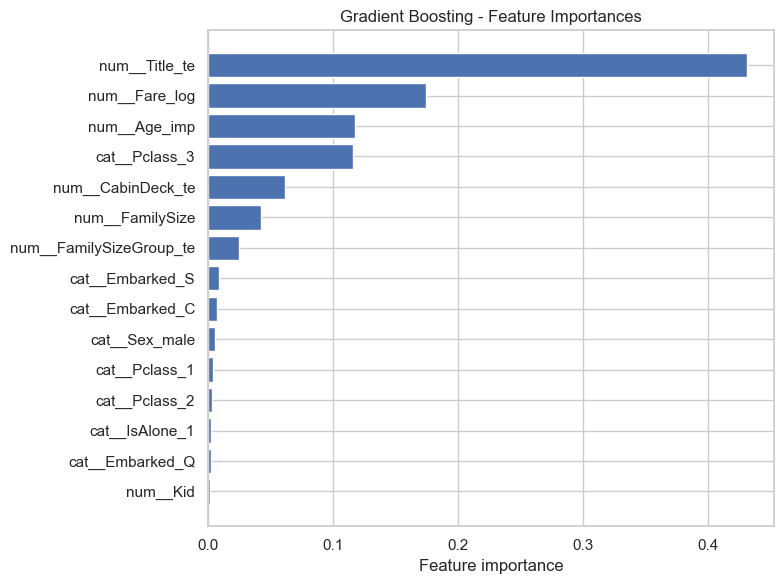

In [120]:
# 8.1 Feature Importance

gb_clf = best_gb.named_steps["clf"]
gb_preprocess = best_gb.named_steps["preprocess"]

try:
    feature_names = gb_preprocess.get_feature_names_out()
except AttributeError:
    feature_names = np.array([f"feature_{i}" for i in range(len(gb_clf.feature_importances_))])

importances = gb_clf.feature_importances_

idx_sorted = np.argsort(importances)[::-1]
feature_names_sorted = feature_names[idx_sorted]
importances_sorted = importances[idx_sorted]

top_k = 15
feature_names_top = feature_names_sorted[:top_k]
importances_top = importances_sorted[:top_k]

plt.figure(figsize=(8, 6))
plt.barh(range(len(importances_top)), importances_top)
plt.yticks(range(len(importances_top)), feature_names_top)
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Gradient Boosting - Feature Importances")
plt.tight_layout()
plt.show()

## Confusion matrix

On a validation split:

- The tuned Gradient Boosting model:
  - Correctly identifies most non-survivors.
  - Also correctly predicts many survivors but produces more **false negatives** than **false positives**.
- This reflects a slight **bias toward predicting non-survival**.

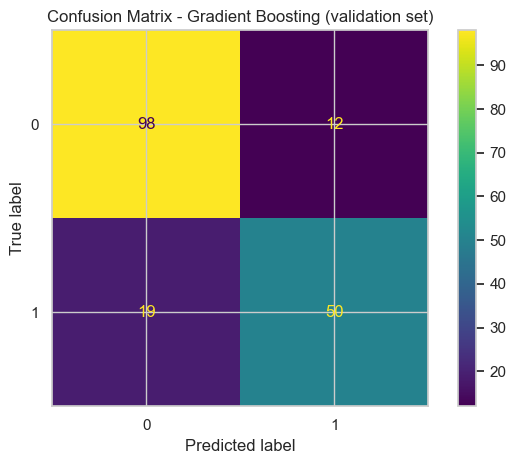

In [121]:
# 8.2 Confusion Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

gb_best_for_cm = clone(best_gb)
gb_best_for_cm.fit(X_train, y_train)

y_valid_pred = gb_best_for_cm.predict(X_valid)

cm = confusion_matrix(y_valid, y_valid_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gb_best_for_cm.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix - Gradient Boosting (validation set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

## Best MLP training curves

For the best MLP configuration:

- Training and validation **loss** curves:
  - Both decrease quickly, then stabilise.
  - Early stopping prevents overfitting.
- Training and validation **accuracy** curves:
  - Increase and level off near the previously observed cross-validation scores.
  - The gap between training and validation accuracy remains moderate, indicating controlled overfitting.

Best MLP architecture (for documentation) :


Model: "TitanicMLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tabular_input (InputLayer)      │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

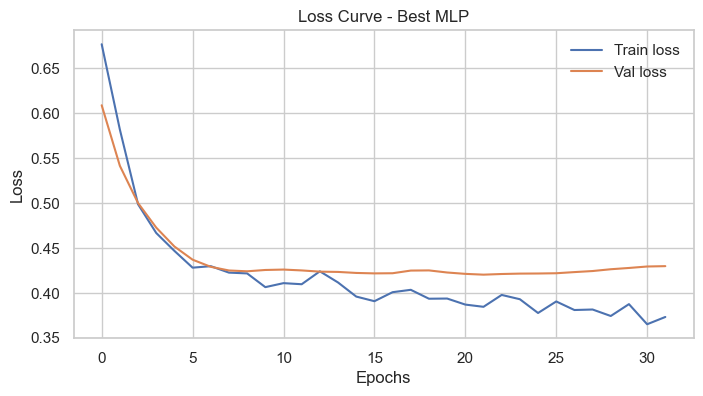

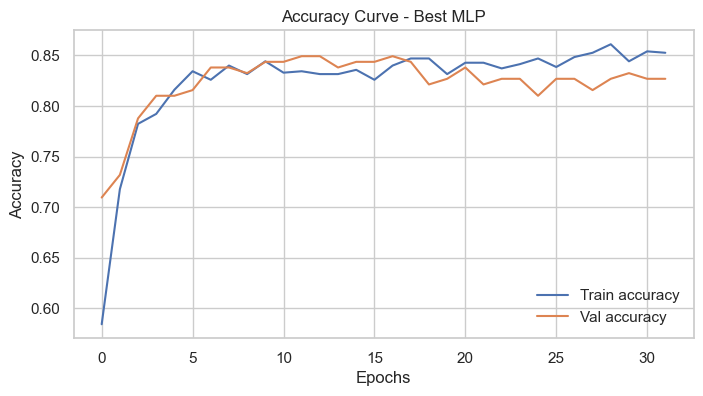

Accuracy visualisation split: 0.8212
This score is NOT used in the comparison table; it serves only to illustrate the model's behavior.


In [122]:
# 8.3 Best MLP model visualisation

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train_vis, X_val_vis, y_train_vis, y_val_vis = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

dl_pipeline_vis = Pipeline(steps=[
    ("features", TitanicFeatureBuilder()),
    ("target_enc", TargetEncoder(cols=te_cols, smoothing=10.0)),
    ("preprocess", preprocessor),
])

X_train_vis_proc = dl_pipeline_vis.fit_transform(X_train_vis, y_train_vis)
X_val_vis_proc = dl_pipeline_vis.transform(X_val_vis)

if not isinstance(X_train_vis_proc, np.ndarray):
    X_train_vis_proc = X_train_vis_proc.toarray()
    X_val_vis_proc = X_val_vis_proc.toarray()

tf.random.set_seed(RANDOM_STATE)
vis_mlp_model = build_mlp(
    input_dim=X_train_vis_proc.shape[1],
    layers_sizes=best_mlp_config["layers"],
    dropout=best_mlp_config["dropout"],
    lr=best_mlp_config["lr"],
)

print("Best MLP architecture (for documentation) :")
vis_mlp_model.summary()

early_stop_vis = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=best_mlp_config.get("patience", 10),
    restore_best_weights=True,
    verbose=0,
)

history_vis = vis_mlp_model.fit(
    X_train_vis_proc,
    y_train_vis,
    validation_data=(X_val_vis_proc, y_val_vis),
    epochs=best_mlp_config["epochs"],
    batch_size=best_mlp_config["batch_size"],
    callbacks=[early_stop_vis],
    verbose=0,
)

def plot_learning_curves(history):
    hist = history.history

    plt.figure(figsize=(8, 4))
    plt.plot(hist["loss"], label="Train loss")
    if "val_loss" in hist:
        plt.plot(hist["val_loss"], label="Val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve - Best MLP")
    plt.legend()
    plt.grid(True)
    plt.show()

    if "accuracy" in hist:
        plt.figure(figsize=(8, 4))
        plt.plot(hist["accuracy"], label="Train accuracy")
        if "val_accuracy" in hist:
            plt.plot(hist["val_accuracy"], label="Val accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Curve - Best MLP")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_learning_curves(history_vis)

val_loss_vis, val_acc_vis = vis_mlp_model.evaluate(X_val_vis_proc, y_val_vis, verbose=0)
print(f"Accuracy visualisation split: {val_acc_vis:.4f}")
print("This score is NOT used in the comparison table; it serves only to illustrate the model's behavior.")

# 9. Final Model Selection

After comparing tuned models and the best MLP, we select the **grid-search-tuned Gradient Boosting Classifier** as the **final model** for submission.

Reasons:

- **Performance**:
  - It is consistently among the **top models** in cross-validated accuracy, very close to the Optuna-tuned version and the tuned Voting Classifier. But more importantly it is better on the test set, showing that the Optuna model is more prone to fitting to noise (due to the small size of our dataset).
- **Simplicity & reproducibility**:
  - The grid-search configuration is **easy to document and reproduce**, with a clear set of discrete hyperparameters.
  - The single-model pipeline is simpler to train, debug, and deploy than a Voting ensemble or an MLP.


Final end-to-end pipeline:

1. `TitanicFeatureBuilder` – imputations, family features, cabin indicators, titles, ticket frequency.
2. `TargetEncoder` – supervised encodings of `Title`, `CabinDeck`, `FamilySizeGroup`.
3. `preprocessor` – numeric scaling and one-hot encoding of remaining categorical variables.
4. **GradientBoostingClassifier (tuned)** – hyperparameters selected via grid search.

This pipeline is then **fitted on the full training dataset** and used to generate predictions for the test set.


# 10. Submission File Generation

Using the final tuned Gradient Boosting pipeline, we generate the **Kaggle submission CSV**:

1. **Predict survival**
   - Apply the fitted pipeline (`best_gb`) directly to `test_df`.
   - Because the pipeline encapsulates **feature engineering**, **target encoding**, **preprocessing**, and the **classifier**, no manual transformations are needed.
   - Obtain binary predictions `test_preds` (0 or 1).

2. **Build submission DataFrame**
   - Two columns:
     - `PassengerId` from `test_df`.
     - `Survived` from `test_preds`.

3. **Export to CSV**
   - Save as `submission_gradient_boosting_tuned.csv` with `index=False`.



In [ ]:
# 10. Submission file generation
test_path = DATA_DIR / "test.csv"
test_df = pd.read_csv(test_path)
assert "PassengerId" in test_df.columns, "PassengerId missing in test.csv"

test_preds = best_gb.predict(test_df)

submission_gb = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_preds.astype(int)
})

submission_filename = "submission_gradient_boosting_tuned.csv"
submission_gb.to_csv(submission_filename, index=False)

print(f"Submission file generated : {submission_filename}")
submission_gb.head()

Submission file generated : submission_gradient_boosting_tuned.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
